In [22]:
library(Rssa)

Loading required package: svd

Attaching package: ‘Rssa’

The following object is masked from ‘package:stats’:

    decompose



In [1]:
library(forecast)
library(ncdf4)
library(ggplot2)

In [27]:
library(Rlibeemd)

If you installed Rlibeemd from CRAN, consider installing again from GitHub if you wish to support for parallel computations: https://github.com/helske/Rlibeemd.


In [6]:
fuzzify<-function(x)
{
  idx = (x == 0)
  if(sum(idx) != 0){
    y <- array(0.0 ,length(x))
    y[idx] <- x[idx] + 0.005*runif(1,min=0.0, max=1.0) 
    y[!idx]<-x[!idx] + 0.005*runif(1,min=-1.0, max=1.0)
    return(y)
  }
  return(x) 
}

phase_average<-function(x, freq)
{    
  N = length(x)
  result = numeric(N)
  averages = numeric(freq)
  stds = numeric(freq)    
  for (j in 1:freq){
    Idx = seq(j,N,12)
    averages[j] = mean(x[Idx])
    stds[j] = sd(x[Idx])
    if(stds[j] == 0){
      result[Idx] =  0
    }else{
      result[Idx] = (x[Idx] - averages[j])/stds[j]
    }
    
  }
  returnList <- list("result" = result, "averages" = averages, "stds" = stds)
  return(returnList)  
}

inv_phase_average<-function(x, freq, avg, std)
{    
  N = length(x)
  result = numeric(N)  
  for (j in 1:freq){
    Idx = seq(j,N,freq)
    result[Idx] = x[Idx]* std[j] + avg[j]      
  }
  return(result)  
}

inBoxCox<-function(x, lambda){
  if(lambda == 0){
    inv_x = exp(x)
  } else{
    inx_x = (x*lambda + 1) ^ (1/lambda)
  }
  return(inx_x)
}


In [3]:
library(quantmod)

Loading required package: xts
Loading required package: zoo

Attaching package: ‘zoo’

The following objects are masked from ‘package:base’:

    as.Date, as.Date.numeric

Loading required package: TTR


ERROR: Error in value[[3L]](cond): Package ‘quantmod’ version 0.4.13 cannot be unloaded:
 Error in unloadNamespace(package) : namespace ‘quantmod’ is imported by ‘tseries’ so cannot be unloaded



In [9]:
df<- read.csv("GBPJPY_30_2018_2018Clean.csv", header=TRUE, sep=",")

In [10]:
x<-df[["Close"]]

In [45]:
load("data.RData")
load("lat.RData")
load("lon.RData")


#x<-data[22,8,2:dim(data)[3]]  #cluster==2
#x<-data[28,7,3:dim(data)[3]]   #cluster==0
#x<-data[1,10,]
#x<-df_cluster[["X1"]]
x.ts<-ts(x, start = c(1948, 1), freq=f)

#x <- fuzzify(x)

n=200
# Set forecasting window length (in years)
m=24
# Set start year
start = 1948
origin = 2700
# Set annual sampling rate
f = 12
h = m*f

index = (origin - start) * f +1

#x.ts <- x[index:length(x)-1]

train_start <- index
train_end <- train_start+n*f-1

test_start <- train_end + 1
test_end <- test_start + m*f -1

x.train <- x[train_start:train_end]
x.test <- x[test_start:test_end]
#reg.train<-df[train_start:train_end,]
#reg.test<-df[test_start:test_end,]

x.ts = ts(x, start=c(origin, 1), freq=f)

x.train <- ts(x.train, start = c(origin, 1), freq=f)
#reg.train <- ts(reg.train, start = c(origin, 1), freq=f)
x.test <- ts(x.test, start = c(origin+n, 1), freq=f)
#reg.test <- ts(reg.test, start = c(origin+n, 1), freq=f)

lambda <- BoxCox.lambda(x.train)

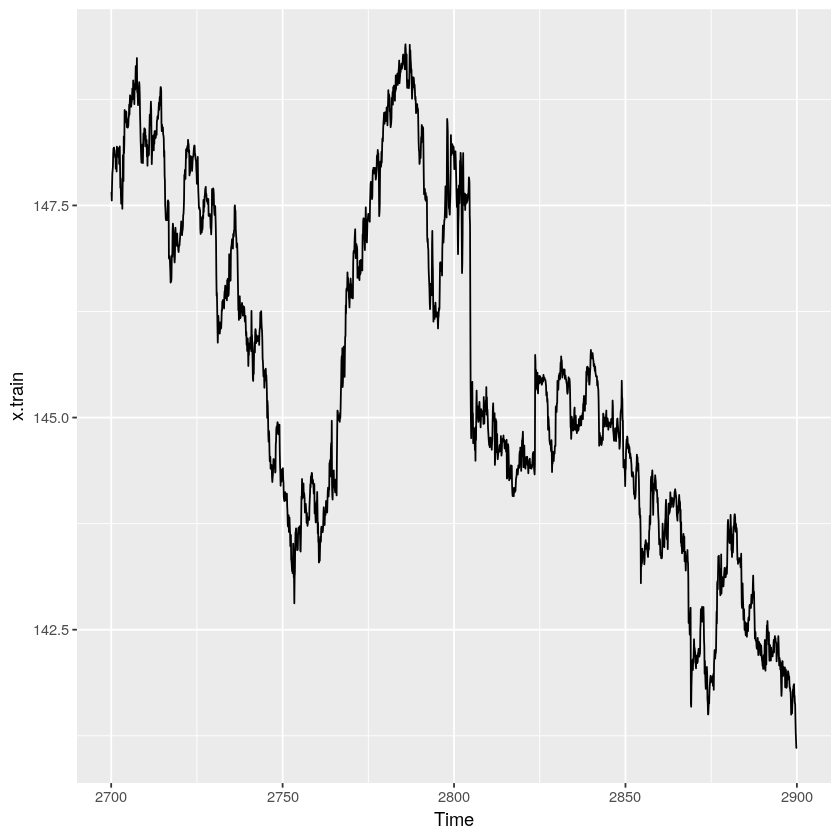

In [46]:
autoplot(x.train)

In [47]:
fit = auto.arima(x.train)

In [48]:
fit

Series: x.train 
ARIMA(0,1,0) 

sigma^2 estimated as 0.01822:  log likelihood=1400.98
AIC=-2799.96   AICc=-2799.96   BIC=-2794.17

In [49]:
A = forecast(fit, h)$mean

In [50]:
accuracy(A, x.test)

ME         RMSE      MAE       MPE        MAPE      ACF1     
Test set -0.7826585 0.8611087 0.7826585 -0.5583723 0.5583723 0.9231177
         Theil's U
Test set 6.581652

Don't know how to automatically pick scale for object of type ts. Defaulting to continuous.
Warning message:
“Removed 1 rows containing missing values (geom_path).”

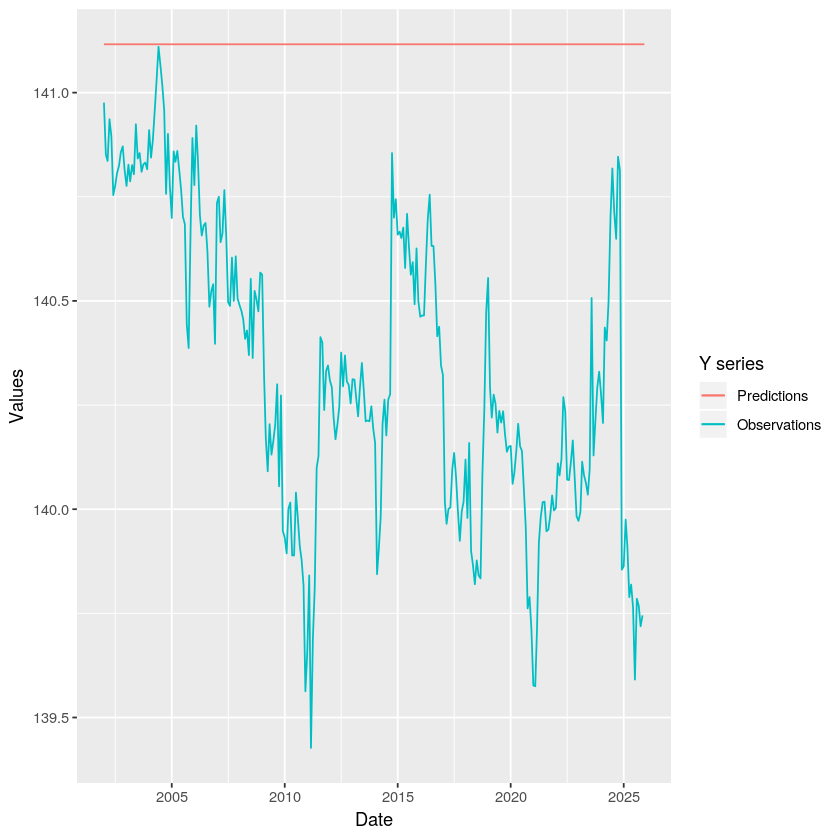

In [51]:
data <- data.frame(
  date = seq(as.Date("2002/1/1"), by = "month", length.out = h),
  x.test,
  A
)

ggplot(data, aes(x=date)) +                    # basic graphical object
  geom_line(aes(y=x.test,colour="red") ) +  # first layer
  geom_line(aes(y=A,colour="blue"))+ ylab("Values")+ xlab("Date")+
  scale_color_discrete(name = "Y series", labels = c("Predictions", "Observations"))

In [67]:
tapply(x.train, cycle(x.train), mean)

ERROR while rich displaying an object: Error in dn[[2L]]: subscript out of bounds

Traceback:
1. FUN(X[[i]], ...)
2. tryCatch(withCallingHandlers({
 .     rpr <- mime2repr[[mime]](obj)
 .     if (is.null(rpr)) 
 .         return(NULL)
 .     prepare_content(is.raw(rpr), rpr)
 . }, error = error_handler), error = outer_handler)
3. tryCatchList(expr, classes, parentenv, handlers)
4. tryCatchOne(expr, names, parentenv, handlers[[1L]])
5. doTryCatch(return(expr), name, parentenv, handler)
6. withCallingHandlers({
 .     rpr <- mime2repr[[mime]](obj)
 .     if (is.null(rpr)) 
 .         return(NULL)
 .     prepare_content(is.raw(rpr), rpr)
 . }, error = error_handler)
7. mime2repr[[mime]](obj)
8. repr_markdown.numeric(obj)
9. repr_vector_generic(html_escape_names(obj), "%s. %s\n", "%s\n:   %s", 
 .     "**%s:** %s", "%s\n\n", item_uses_numbers = TRUE, escape_fun = html_escape)
10. html_escape_names(obj)
11. .escape_names(obj, "html")
12. colnames(obj)
ERROR while rich displaying an object: 

1          2          3          4          5          6          7 
-0.7414405 -0.9836599 -1.0032326 -1.5937090 -1.7202721 -0.4179690 -0.9521062 
         8          9         10         11         12 
-1.1856452 -0.7448901 -0.5975455 -1.1639104 -1.1113434

In [52]:
AC + seasons

           Jan       Feb       Mar       Apr       May       Jun       Jul
2013 -19.60260 -23.57155 -18.91517 -22.99433 -23.61112 -18.78164 -23.13159
2014 -22.29791 -25.47337 -18.33858 -23.61671 -24.21479 -18.69549 -21.76044
2015 -22.49347 -25.58822 -18.33650 -23.65174 -24.49201 -18.59648 -21.41379
           Aug       Sep       Oct       Nov       Dec
2013 -21.88682 -25.93497 -26.79871 -26.06119 -23.32542
2014 -21.08598 -24.60379 -26.86120 -25.13567 -25.37538
2015 -20.81395 -24.24335 -26.85935 -24.88025 -25.96276

In [53]:
AC

           Jan       Feb       Mar       Apr       May       Jun       Jul
2013 -20.12485 -21.05104 -23.68098 -22.43941 -22.10914 -23.33520 -24.96611
2014 -22.82015 -22.95286 -23.10438 -23.06180 -22.71280 -23.24906 -23.59496
2015 -23.01572 -23.06772 -23.10230 -23.09682 -22.99003 -23.15004 -23.24831
           Aug       Sep       Oct       Nov       Dec
2013 -24.29312 -24.94634 -23.04783 -24.39282 -20.22826
2014 -23.49228 -23.61516 -23.11032 -23.46729 -22.27822
2015 -23.22025 -23.25472 -23.10848 -23.21187 -22.86560

In [54]:
dec = decompose(x.train)
seasons = dec$seasonal[seq(1:12)]
x.train.t = seasadj(dec)
AC = forecast(auto.arima(x.train.t),h=h)$mean
#AC = AC + seasons

accuracy(AC, x.test)


ME         RMSE    MAE      MPE     MAPE    ACF1      Theil's U
Test set -0.4597077 4.88777 4.032243 100.008 100.008 0.2675107 0.9650306

In [ ]:
Forex

# SARIMA

Without xreg

In [69]:
fit = ets(x.train)

In [70]:
fit

ETS(A,N,N) 

Call:
 ets(y = x.train) 

  Smoothing parameters:
    alpha = 0.044 

  Initial states:
    l = -4.2688 

  sigma:  5.3955

     AIC     AICc      BIC 
3336.600 3336.668 3348.259 

In [71]:
A = forecast(fit,h=h)$mean
accuracy(A, x.test)

ME         RMSE     MAE      MPE      MAPE     ACF1      Theil's U
Test set -0.5635502 4.898267 4.037051 99.87475 99.87475 0.2673559 0.970374

Don't know how to automatically pick scale for object of type ts. Defaulting to continuous.


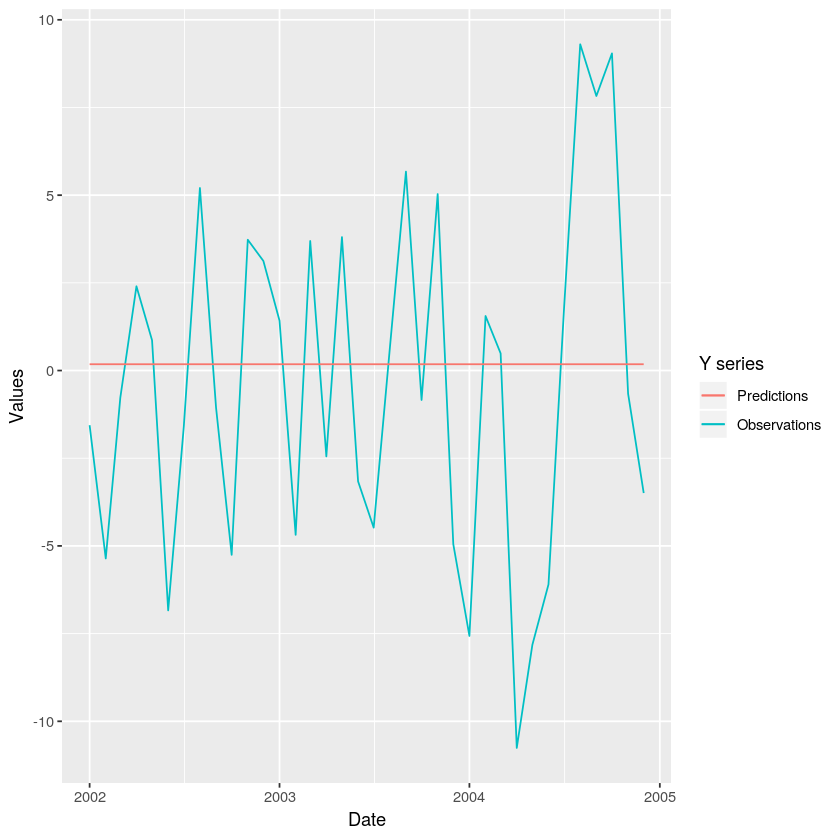

In [72]:
data <- data.frame(
  date = seq(as.Date("2002/1/1"), by = "month", length.out = 36),
  x.test,
  A
)

ggplot(data, aes(x=date)) +                    # basic graphical object
  geom_line(aes(y=x.test,colour="red") ) +  # first layer
  geom_line(aes(y=A,colour="blue"))+ ylab("Values")+ xlab("Date")+
  scale_color_discrete(name = "Y series", labels = c("Predictions", "Observations"))

With xreg

In [91]:
fit = auto.arima(x.train, xreg = reg.train)

In [92]:
fit

Series: x.train 
Regression with ARIMA(1,0,0)(1,0,0)[12] errors 

Coefficients:
         ar1    sar1  intercept       X0      X1      X2      X3      X4
      0.2023  0.3009    14.1647  -1.1367  0.3578  0.0606  0.2574  0.1482
s.e.  0.0569  0.0558     3.7431   0.8681  0.1625  0.1776  0.1970  0.2231
           X5       X6       X7       X8      X9     X10      X11      X12
      -0.0951  -0.2037  -0.1730  -0.2108  0.1170  0.1185  -0.1405  -0.0028
s.e.   0.2419   0.2287   0.0943   0.1260  0.0921  0.0511   0.1482   0.1474
          X13      X14     X15      X16     X17     X18     X19      X20
      -0.0417  -0.1407  0.1646  -0.1713  0.0223  0.0385  0.0226  -0.0584
s.e.   0.1010   0.0596  0.2062   0.1560  0.1151  0.0955  0.1014   0.1094
          X21     X22     X23      X24      X25      X26     X27      X28
      -0.0173  0.0922  0.0997  -0.0112  -0.1031  -0.0607  0.0561  -0.0711
s.e.   0.0796  0.0857  0.0976   0.0810   0.0959   0.0807  0.0348   0.0346
          X29      X30     X31     

In [93]:
A = forecast(fit,h=h, xreg = reg.test)$mean
accuracy(A, x.test)

ME        RMSE     MAE      MPE       MAPE     ACF1      Theil's U
Test set -5.300596 11.20758 8.956891 -6190.434 6867.152 0.3600934 2.691169

# ARIMA with Phase Averaging

Without xreg

In [59]:
pa <- phase_average(x.train, f)
x.train.t <- ts(pa$result, start = c(origin, 1), freq=f)
fit = auto.arima(x.train.t)

In [60]:
fit

Series: x.train.t 
ARIMA(1,1,1) 

Coefficients:
         ar1      ma1
      0.1603  -0.9653
s.e.  0.0543   0.0142

sigma^2 estimated as 0.9191:  log likelihood=-494.43
AIC=994.87   AICc=994.93   BIC=1006.52

In [61]:
APA = forecast(fit,h=h)$mean
APA = inv_phase_average(APA, f, pa$averages, pa$stds)
accuracy(APA, x.test)

ME         RMSE     MAE      MPE      MAPE     ACF1      Theil's U
Test set -0.4545582 4.892604 4.108212 106.8576 106.8576 0.2337216 0.9343308

Don't know how to automatically pick scale for object of type ts. Defaulting to continuous.


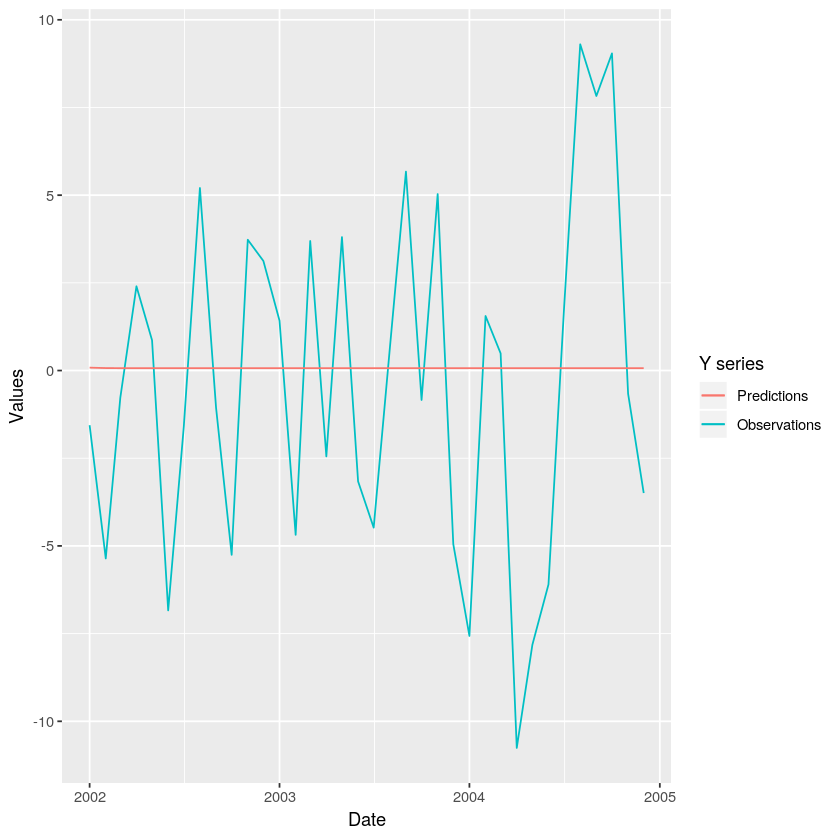

In [62]:
data <- data.frame(
  date = seq(as.Date("2002/1/1"), by = "month", length.out = 36),
  x.test,
  A
)

ggplot(data, aes(x=date)) +                    # basic graphical object
  geom_line(aes(y=x.test,colour="red") ) +  # first layer
  geom_line(aes(y=A,colour="blue"))+ ylab("Values")+ xlab("Date")+
  scale_color_discrete(name = "Y series", labels = c("Predictions", "Observations"))

With xreg

In [97]:
pa <- phase_average(x.train, f)
x.train.t <- ts(pa$result, start = c(origin, 1), freq=f)
fit = auto.arima(x.train.t, xreg = reg.train)

In [98]:
fit

Series: x.train.t 
Regression with ARIMA(0,0,0) errors 

Coefficients:
           X0      X1       X2      X3      X4       X5       X6       X7
      -0.0866  0.0253  -0.0014  0.0084  0.0173  -0.0113  -0.0043  -0.0041
s.e.   0.0555  0.0101   0.0112  0.0124  0.0143   0.0149   0.0145   0.0056
           X8      X9     X10     X11     X12      X13      X14      X15
      -0.0017  0.0098  0.0047  -0.011  0.0016  -0.0058  -0.0021  -0.0004
s.e.   0.0066  0.0055  0.0032   0.009  0.0081   0.0058   0.0037   0.0108
         X16      X17      X18      X19      X20      X21     X22     X23
      0.0062  -0.0005  -0.0003  -0.0046  -0.0024  -0.0006  0.0028  0.0025
s.e.  0.0080   0.0053   0.0053   0.0045   0.0046   0.0043  0.0044  0.0054
         X24      X25      X26     X27      X28      X29      X30     X31
      0.0013  -0.0064  -0.0101  0.0006  -0.0023  -0.0061  -0.0011  0.0073
s.e.  0.0044   0.0054   0.0044  0.0019   0.0022   0.0036   0.0042  0.0031
         X32     X33      X34      X35
     

In [99]:
APA = forecast(fit,h=h, xreg = reg.test)$mean
APA = inv_phase_average(APA, f, pa$averages, pa$stds)
accuracy(APA, x.test)

ME        RMSE     MAE      MPE       MAPE     ACF1       Theil's U
Test set -2.470408 8.868144 6.234476 -5750.702 6253.062 0.07483381 1.298139

In [60]:
pa.reg <- phase_average(reg.train, f)
reg.train.t <- ts(pa.reg$result, start = c(origin, 1), freq=f)

In [61]:
pa.reg <- phase_average(reg.test, f)
reg.test.t <- ts(pa.reg$result, start = c(origin, 1), freq=f)

In [62]:
pa <- phase_average(x.train, f)
x.train.t <- ts(pa$result, start = c(origin, 1), freq=f)

APA = forecast(auto.arima(x.train.t, xreg = reg.train.t),h=h, xreg = reg.test.t)$mean
APA = inv_phase_average(APA, f, pa$averages, pa$stds)
accuracy(APA, x.test)

ME       RMSE     MAE      MPE       MAPE     ACF1         Theil's U
Test set 4.471858 16.50212 7.658605 -47.46895 91.04524 -0.008679608 1.003441

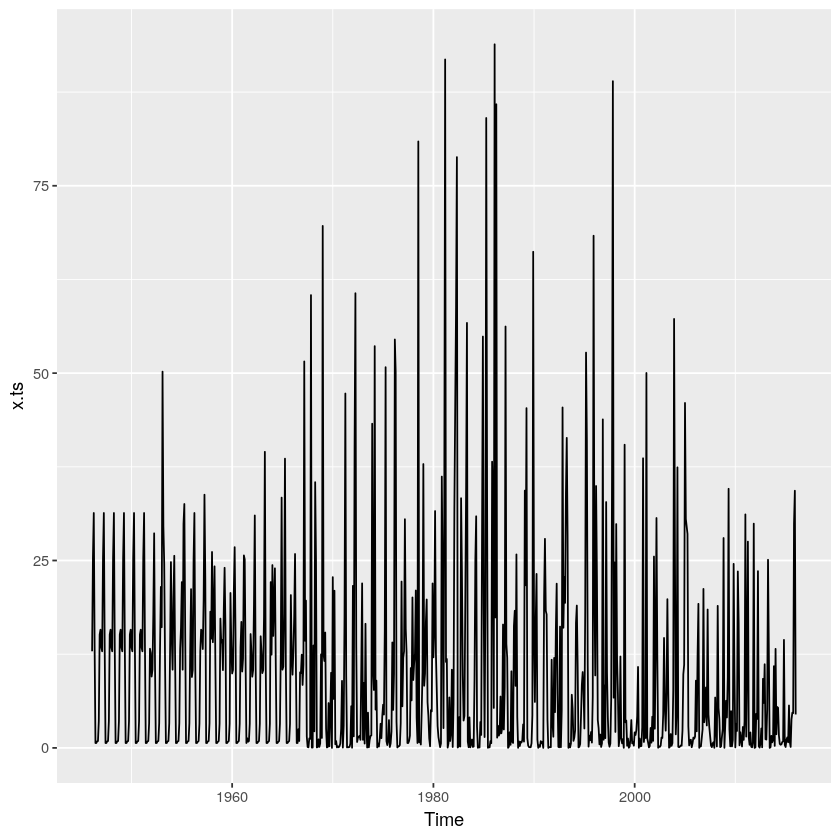

In [194]:
autoplot(x.ts)

In [166]:
df <- df_cluster[["X5"]]
df <- df[1:length(df)-1]

x<-data[22,8,2:dim(data)[3]]   #cluster==0

x.ts<-ts(x, start = c(1946, 2), freq=f)

x <- fuzzify(x)

n_train = 30
# Set forecasting window length (in years)
n_test = 3
# Set start year
start_year = 1946
# Set annual sampling rate
f = 12
h = n_test * f

In [167]:
RMSE.A = array(0.0, (end_year-(n_train+n_test))-start_year+1)
MAE.A = array(0.0, (end_year-(n_train+n_test))-start_year+1)
errorRatio.A = array(0.0, (end_year-(n_train+n_test))-start_year+1)

RMSE.E = array(0.0, (end_year-(n_train+n_test))-start_year+1)
MAE.E = array(0.0, (end_year-(n_train+n_test))-start_year+1)
errorRatio.E = array(0.0, (end_year-(n_train+n_test))-start_year+1)

x.ts <- x[1:length(x)]
origin = start_year - 1
N = length(x.ts)

In [168]:
for(z in seq(1,N/f - n_train - n_test + 1)){

    train_start = (z - 1)*f + 1
    train_end = train_start + n_train*f - 1

    test_start = train_end + 1
    test_end = test_start + n_test*f - 1


    x.train <- x[train_start:train_end]
    x.test <- x[test_start:test_end]

    x.train <- ts(x.train, start = c(origin+z, 2), freq=f)
    x.test <- ts(x.test, start = c(origin+z+n_train, 2), freq=f)
    
    reg.train<-df[train_start:train_end]
    #reg.train <- ts(reg.train, start = c(origin+z, 1), freq=f)
    
    reg.test<-df[test_start:test_end]
    #reg.test <- ts(reg.test, start = c(origin+z+n_train, 1), freq=f)
    
    
    #lambda <- BoxCox.lambda(x.train)
    
          
    #OM + PA
    pa = phase_average(x.train, f)
    x.train.t <- ts(pa$result, start = c(origin, 1), freq=f)

    APA = forecast(auto.arima(x.train.t),h=h)$mean
    APA = inv_phase_average(APA, f, pa$averages, pa$stds)
    
    #OM + PA + reg
    pa <- phase_average(x.train, f)
    x.train.t <- ts(pa$result, start = c(origin, 2), freq=f)
    fit = auto.arima(x.train.t, xreg = reg.train)


    APAreg = forecast(fit,h=h, xreg = reg.test)$mean
    APAreg = inv_phase_average(APAreg, f, pa$averages, pa$stds)


    error.A = accuracy(APA, x.test)
    error.E = accuracy(APAreg, x.test)

    RMSE.A[z] = as.numeric(error.A[1,2])
    MAE.A[z] = as.numeric(error.A[1,3])
    errorRatio.A[z] = RMSE.A[z]/mean(x.test)


    RMSE.E[z] = as.numeric(error.E[1,2])
    MAE.E[z] = as.numeric(error.E[1,3])
    errorRatio.E[z] = RMSE.E[z]/mean(x.test)

  }

  # Now calculate average forecast errors
  meanRMSE.A = mean(RMSE.A, na.rm=TRUE)
  meanRMSE.E = mean(RMSE.E, na.rm=TRUE)
  meanErrorRatio.A = mean(errorRatio.A)
#
  meanMAE.A = mean(MAE.A, na.rm=TRUE)
  meanMAE.E = mean(MAE.E, na.rm=TRUE)
  meanErrorRatio.E = mean(errorRatio.E)

In [169]:
meanRMSE.A

[1] 0.8742107

In [170]:
meanRMSE.E

[1] 0.8750485

In [171]:
RMSE.A

[1] 0.8588476 0.8394635 1.8444849 1.7967749 1.8111312 0.8488783 0.8734240
 [8] 0.7975420 0.7143117 0.6614540 1.0527750 1.0884030 1.0902102 0.6489137
[15] 0.5092792 0.4443741 2.2025326 2.2075980 2.2178985 0.4911700 0.6264962
[22] 0.6169570 0.6463264 0.3675730 0.5544083 0.4142659 0.4002536 0.3622873
[29] 0.3726997 0.8187155 0.8310660 0.8273734 0.4133237 0.3958647 0.4380604
[36] 0.5862562 0.7895757 0.7590367

In [172]:
RMSE.E

[1] 0.8447546 0.8427315 1.8634804 1.8163707 1.8244527 0.8292430 0.8712799
 [8] 0.8042292 0.7310645 0.6630726 1.0539238 1.0862449 1.0901911 0.6491052
[15] 0.5128778 0.4433634 2.1938735 2.2027119 2.2163627 0.4923348 0.6303265
[22] 0.6179544 0.6469727 0.3676246 0.5431550 0.4127493 0.4007342 0.3622470
[29] 0.3748479 0.8220968 0.8364507 0.8282862 0.4129432 0.3936346 0.4438143
[36] 0.5817418 0.7806669 0.7639302

In [7]:
#df <- df_cluster[1:dim(df_cluster)[1]-1,2:7]

#x<-data[22,8,2:dim(data)[3]]   #cluster==0
x<-data[22,8,] 
x.ts<-ts(x, start = c(1946, 2), freq=f)

x <- fuzzify(x)

n_train = 30
# Set forecasting window length (in years)
n_test = 3
# Set start year
start_year = 1946
# Set annual sampling rate
f = 12
h = n_test * f

RMSE.A = array(0.0, (end_year-(n_train+n_test))-start_year+1)
MAE.A = array(0.0, (end_year-(n_train+n_test))-start_year+1)
errorRatio.A = array(0.0, (end_year-(n_train+n_test))-start_year+1)

RMSE.E = array(0.0, (end_year-(n_train+n_test))-start_year+1)
MAE.E = array(0.0, (end_year-(n_train+n_test))-start_year+1)
errorRatio.E = array(0.0, (end_year-(n_train+n_test))-start_year+1)

x.ts <- x[1:length(x)]
origin = start_year - 1
N = length(x.ts)

In [180]:
for(z in seq(1,N/f - n_train - n_test + 1)){

    train_start = (z - 1)*f + 1
    train_end = train_start + n_train*f - 1

    test_start = train_end + 1
    test_end = test_start + n_test*f - 1


    x.train <- x[train_start:train_end]
    x.test <- x[test_start:test_end]

    x.train <- ts(x.train, start = c(origin+z, 2), freq=f)
    x.test <- ts(x.test, start = c(origin+z+n_train, 2), freq=f)
    
    reg.train<-df[train_start:train_end,]
    #reg.train <- ts(reg.train, start = c(origin+z, 1), freq=f)
    
    reg.test<-df[test_start:test_end,]
    #reg.test <- ts(reg.test, start = c(origin+z+n_train, 1), freq=f)
    
    
    #lambda <- BoxCox.lambda(x.train)
    
          
    #OM + PA
    pa = phase_average(x.train, f)
    x.train.t <- ts(pa$result, start = c(origin, 1), freq=f)

    APA = forecast(auto.arima(x.train.t),h=h)$mean
    APA = inv_phase_average(APA, f, pa$averages, pa$stds)
    
    #OM + PA + reg
    pa <- phase_average(x.train, f)
    x.train.t <- ts(pa$result, start = c(origin, 2), freq=f)
    fit = auto.arima(x.train.t, xreg = reg.train)


    APAreg = forecast(fit,h=h, xreg = reg.test)$mean
    APAreg = inv_phase_average(APAreg, f, pa$averages, pa$stds)


    error.A = accuracy(APA, x.test)
    error.E = accuracy(APAreg, x.test)

    RMSE.A[z] = as.numeric(error.A[1,2])
    MAE.A[z] = as.numeric(error.A[1,3])
    errorRatio.A[z] = RMSE.A[z]/mean(x.test)


    RMSE.E[z] = as.numeric(error.E[1,2])
    MAE.E[z] = as.numeric(error.E[1,3])
    errorRatio.E[z] = RMSE.E[z]/mean(x.test)

  }

  # Now calculate average forecast errors
  meanRMSE.A = mean(RMSE.A, na.rm=TRUE)
  meanRMSE.E = mean(RMSE.E, na.rm=TRUE)
  meanErrorRatio.A = mean(errorRatio.A)
#
  meanMAE.A = mean(MAE.A, na.rm=TRUE)
  meanMAE.E = mean(MAE.E, na.rm=TRUE)
  meanErrorRatio.E = mean(errorRatio.E)

In [181]:
meanRMSE.A

[1] 0.8743109

In [182]:
meanRMSE.E

[1] 0.8678632

In [183]:
RMSE.A

[1] 0.8589656 0.8395908 1.8446158 1.7969012 1.8112616 0.8490007 0.8735378
 [8] 0.7976710 0.7144197 0.6615381 1.0528245 1.0884502 1.0902580 0.6490078
[15] 0.5093833 0.4444844 2.2026976 2.2077700 2.2180706 0.4912082 0.6265487
[22] 0.6170142 0.6463355 0.3675839 0.5547292 0.4142737 0.4002500 0.3623157
[29] 0.3728776 0.8189466 0.8312700 0.8275776 0.4134209 0.3959328 0.4379972
[36] 0.5862739 0.7896541 0.7591542

In [184]:
RMSE.E

[1] 0.7958603 0.8116940 1.8291363 1.7874360 1.7972514 0.7773137 0.8631777
 [8] 0.8621034 0.8232466 0.6400642 0.9909432 0.9852266 1.0208749 0.5373762
[15] 0.4962345 0.4783208 2.1850615 2.1863813 2.1924225 0.3109133 0.5990647
[22] 0.6585247 0.6898626 0.4821139 0.5859177 0.5025257 0.4178741 0.4312433
[29] 0.3957915 0.7741675 0.8241211 0.7735374 0.4180347 0.3166530 0.4594898
[36] 0.6271734 0.8389656 0.8127027

In [100]:
z<-1

In [122]:
train_start = (z - 1)*f + 1
    train_end = train_start + n_train*f - 1

    test_start = train_end + 1
    test_end = test_start + n_test*f - 1


    x.train <- x[train_start:train_end]
    x.test <- x[test_start:test_end]

    x.train <- ts(x.train, start = c(origin+z, 2), freq=f)
    x.test <- ts(x.test, start = c(origin+z+n_train, 2), freq=f)
    
    reg.train<-df[train_start:train_end]
    #reg.train <- ts(reg.train, start = c(origin+z, 1), freq=f)
    
    reg.test<-df[test_start:test_end]
    #reg.test <- ts(reg.test, start = c(origin+z+n_train, 1), freq=f)
    
    
    #lambda <- BoxCox.lambda(x.train)
    
          
    #OM + PA
    #pa = phase_average(x.train, f)
    #x.train.t <- ts(pa$result, start = c(origin, 1), freq=f)

    #APA = forecast(auto.arima(x.train.t),h=h)$mean
    #APA = inv_phase_average(APA, f, pa$averages, pa$stds)
    
    #OM + PA + reg
    pa <- phase_average(x.train, f)
    x.train.t <- ts(pa$result, start = c(origin, 2), freq=f)
    fit = auto.arima(x.train.t, xreg = reg.train)


    APAreg = forecast(fit,h=h, xreg = reg.test)$mean
    APAreg = inv_phase_average(APAreg, f, pa$averages, pa$stds)



    #error.A = accuracy(APA, x.test)
    error.E = accuracy(APAreg, x.test)

In [123]:
error.E

ME       RMSE     MAE      MPE       MAPE     ACF1         Theil's U
Test set 4.206211 16.43872 7.673053 -49.10466 91.45285 -0.009317391 1.003731

In [110]:
train_start

[1] 1

In [74]:
df_cluster <- read.csv("df_cluster.csv", header=TRUE, sep=",")

In [82]:
df_cluster[["X5"]]

[1]   2.25824801  -2.43190472  -2.63077595  -3.04786750  -1.87783211
  [6]  -2.72052997  -3.68451440  -4.04695564   0.98677666   5.73249118
 [11]   1.18398371   1.42219739  -1.72488117   6.48300698  -3.32398144
 [16]   3.12179017   2.52186006   2.72441415  -0.41755017   6.21279247
 [21]   4.60089333  -3.32017606  -0.25519464   6.91489789   0.13994781
 [26]   2.60239108  -2.91398467   4.31006145   0.23713435   1.41403928
 [31]  -1.44386216   0.50133484   0.09045858  -1.54682411   0.39421802
 [36]  -1.49745344  -1.84153376  -2.53275550   1.10589681  -3.26933116
 [41]   2.04760087   1.54723652   5.47201332   2.69113783   4.37009716
 [46]   0.25538882   0.54069434  -3.52686956   5.59841443  -2.84219108
 [51]   0.60657560   2.83834710   2.57375703  -0.51022727  -1.25334924
 [56]  -1.65465398  -2.29309907   1.27560510   0.09266761  -1.85249324
 [61]   1.68825158   0.42024515   4.89430174  -8.28195716   5.25616834
 [66]  -1.47386521  -0.71242322  -0.27681647   0.55239527  11.95738627
 [71]   4.19756924  -4.10529945   1.44682789   4.18701894   1.54826350
 [76]   1.48856401   0.48231835   2.31191575   0.79635999  -2.77975765
 [81]   6.00638596   2.98734277   3.16349126   3.73678737   0.30983992
 [86]  10.63434695   2.74201564  -5.22554155   4.95028173   0.16015522
 [91]   2.15061050  -4.28511939  -3.31772472   0.08110151   0.49967720
 [96]  -3.43709713  -1.04319198  12.23470043   5.83481998   4.36825316
[101]   2.33194378   0.99573657  -4.75898270  -0.82429921   1.49424312
[106]   7.50638587   4.75537725  -0.28019850   6.13112735  -2.66741984
[111]   6.73061115   1.19613157   3.33867610   3.73633385   3.54944583
[116]  -1.21394625   5.36699878   5.58404253  -1.37939340   2.66059421
[121]  -2.93135008   5.31288475   9.21849785   0.97824532  -2.57031540
[126]   0.18731264  -5.48937948  -6.53286317  -0.58024199  -0.60502188
[131]   2.18447306  10.26558811   1.71024273  -3.76066611   7.44754466
[136]   1.71455128   2.85942915   1.94713993   2.65390612   1.87133811
[141]   1.22564768   4.47959669   6.89048400  11.17846908   4.95500160
[146]  -5.36716464  -1.19255904   3.91102086  -0.50905426  -3.76108021
[151] -10.94745422  -4.48031294  -3.45748575  -3.73117260   6.52618965
[156]   6.67818954   5.17658405   0.20852200   1.81453560   2.35521176
[161]   1.00674498  -1.10892177   1.14548373  -1.77798406   5.07279632
[166]   0.16947642   6.38967750   0.91573332   2.52915644   1.41052092
[171]   4.16147772   6.32509752  -0.35553848   5.49440998  -0.74969873
[176]   0.26570001   5.16291438   3.68086078  -2.45949052  11.17916741
[181]   5.03675743  -4.02132171  -2.80604909   4.02634192  -4.10294026
[186]   0.33828085   4.10031097  -5.90168732   5.06014772   2.03677376
[191]   0.06602998  -4.34890530  -3.76746707  -1.43285179   7.64460648
[196]   3.86130165   1.26678836   6.93285331  -0.75166734   1.96563320
[201]   1.06995518   4.49727038  13.45435790   0.48837318   4.42678040
[206]   6.24712093  -0.42308818   5.26849652   3.07036918   0.18251693
[211]   9.87861913   4.48032993  -0.16170390   1.15157497   0.19520572
[216]  -0.33968010  -0.02806987  -3.34919780   0.46068263   2.48042235
[221]   0.34926672   2.40882846  -2.93896290  -4.32269905   2.11849706
[226]   0.81077777  -0.51907271   7.53912867   4.76641088   3.64366441
[231]   1.47018342   0.50161282  -3.56875745   3.39874576   2.12878105
[236]   2.84331166  -1.00196996  -2.73715111  -3.92681025  -4.07653311
[241]   2.09301669  -2.24580147   1.82499187   7.15776954   2.52275156
[246]   5.98390006   0.44640985   3.80132261  -2.19226894  -0.41375372
[251]   3.08637479  -2.50058443  -3.97323779  -2.02558756  -0.54061394
[256]  -2.36267512  -4.19900285   4.10562890  -2.33359494  -0.53754030
[261]   3.14804841  -0.75843253  -3.24289061   3.71496749   3.16834037
[266]   2.36079838  -0.67287639   2.68716470   0.54944407   3.42996762
[271]   5.32744111   5.74789191   2.52373544  -1.21187324   4.29220508
[276]   3.14227529   2.03801610   1.93649562   9.75974068   1.52914198
[281]  -0.34260642   0.766

In [77]:
length(x)

[1] 841

In [34]:
ABC = forecast(auto.arima(x.train,lambda=lambda), h=h, lambda=lambda, biasadj=TRUE)$mean
accuracy(ABC, x.test)

ME         RMSE     MAE       MPE       MAPE     ACF1        Theil's U
Test set 0.03992951 1.236406 0.4041892 -179.9316 204.0231 -0.04751287 1.054314

Don't know how to automatically pick scale for object of type ts. Defaulting to continuous.


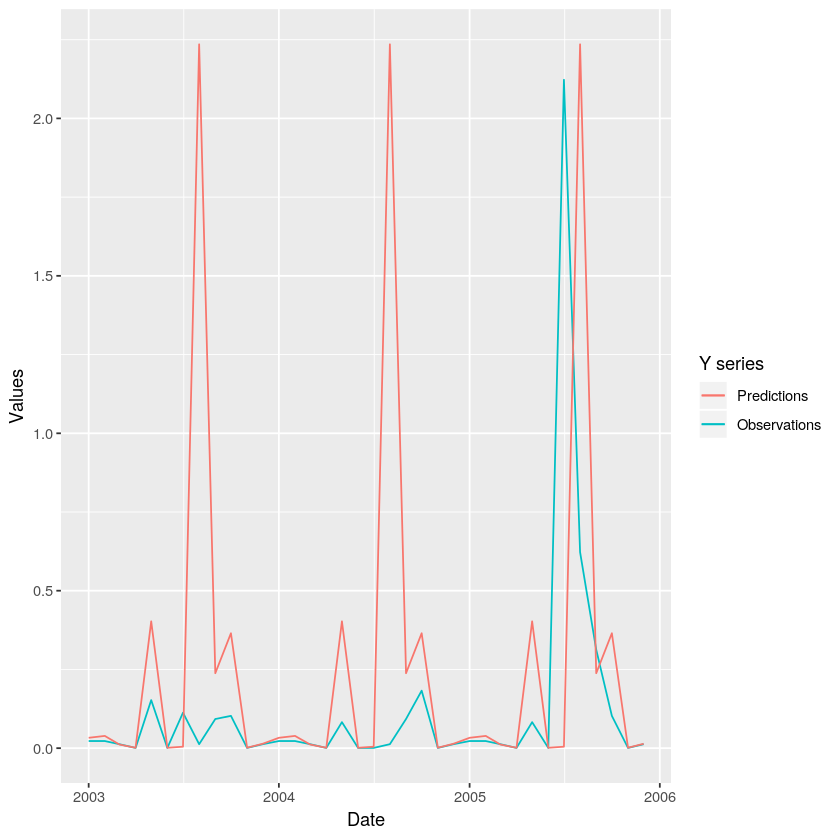

In [43]:
data <- data.frame(
  date = seq(as.Date("2003/1/1"), by = "month", length.out = 36),
  x.test,
  ABC
)

ggplot(data, aes(x=date)) +                    # basic graphical object
  geom_line(aes(y=x.test,colour="red") ) +  # first layer
  geom_line(aes(y=ABC,colour="blue"))+ ylab("Values")+ xlab("Date")+
  scale_color_discrete(name = "Y series", labels = c("Predictions", "Observations"))

In [35]:
pa <- phase_average(x.train, f)
x.train.t <- ts(pa$result, start = c(origin, 1), freq=f)

APA = forecast(auto.arima(x.train.t),h=h)$mean
APA = inv_phase_average(APA, f, pa$averages, pa$stds)
accuracy(APA, x.test)

ME         RMSE    MAE       MPE       MAPE     ACF1        Theil's U
Test set -0.1349061 1.25515 0.4642949 -781.1714 790.1164 -0.05853387 1.988515

Don't know how to automatically pick scale for object of type ts. Defaulting to continuous.


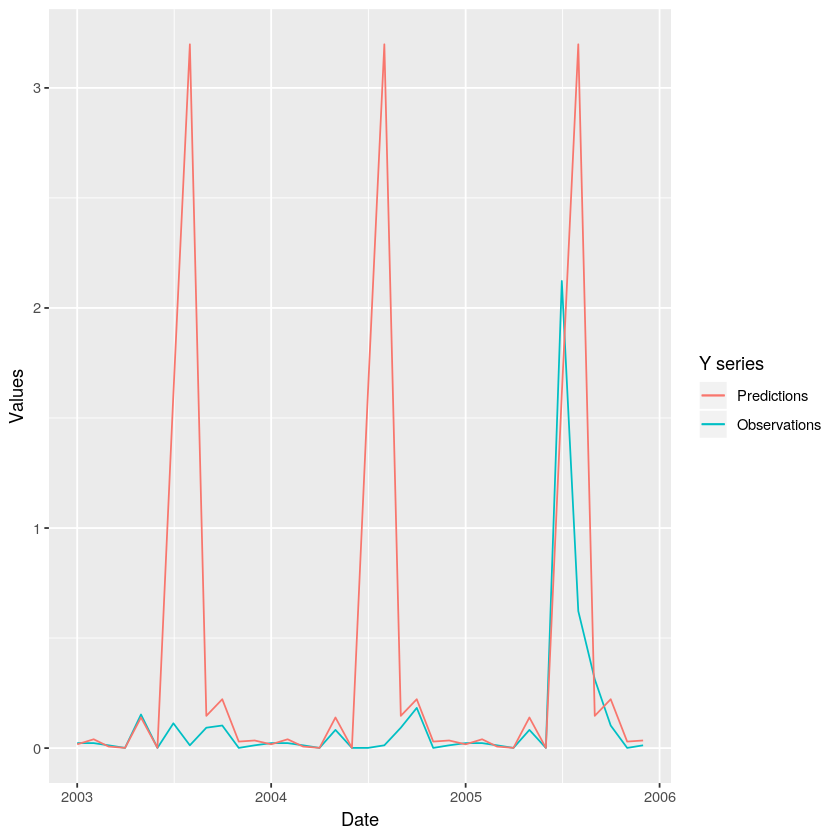

In [44]:
data <- data.frame(
  date = seq(as.Date("2003/1/1"), by = "month", length.out = 36),
  x.test,
  APA
)

ggplot(data, aes(x=date)) +                    # basic graphical object
  geom_line(aes(y=x.test,colour="red") ) +  # first layer
  geom_line(aes(y=APA,colour="blue"))+ ylab("Values")+ xlab("Date")+
  scale_color_discrete(name = "Y series", labels = c("Predictions", "Observations"))

# SSA

In [4]:
load("data.RData")
load("lat.RData")
load("lon.RData")


#x<-data[22,8,2:dim(data)[3]]  #cluster==2
#x<-data[28,7,3:dim(data)[3]]   #cluster==0
x<-data[7,9,]
#x<-df_cluster[["X1"]]
x.ts<-ts(x, start = c(1948, 1), freq=f)

#x <- fuzzify(x)

n=30
# Set forecasting window length (in years)
m=3
# Set start year
start = 1948
origin = 1983
# Set annual sampling rate
f = 12
h = m*f

index = (origin - start) * f +1

#x.ts <- x[index:length(x)-1]

train_start <- index
train_end <- train_start+n*f-1

test_start <- train_end + 1
test_end <- test_start + m*f -1

x.train <- x[train_start:train_end]
x.test <- x[test_start:test_end]
#reg.train<-df[train_start:train_end,]
#reg.test<-df[test_start:test_end,]

x.ts = ts(x, start=c(origin, 1), freq=f)

x.train <- ts(x.train, start = c(origin, 1), freq=f)
#reg.train <- ts(reg.train, start = c(origin, 1), freq=f)
x.test <- ts(x.test, start = c(origin+n, 1), freq=f)
#reg.test <- ts(reg.test, start = c(origin+n, 1), freq=f)

lambda <- BoxCox.lambda(x.train)

In [20]:
autoplot(x)

ERROR: Error: Objects of type numeric not supported by autoplot.


In [34]:
L = 7
s <- ssa(x[1:1000], L = L)
# Reconstruction stage
# The results are the reconstructed series r$F1, r$F2, and r$F3
recon <- reconstruct(s)
# Calculate the residuals
res <- residuals(recon)

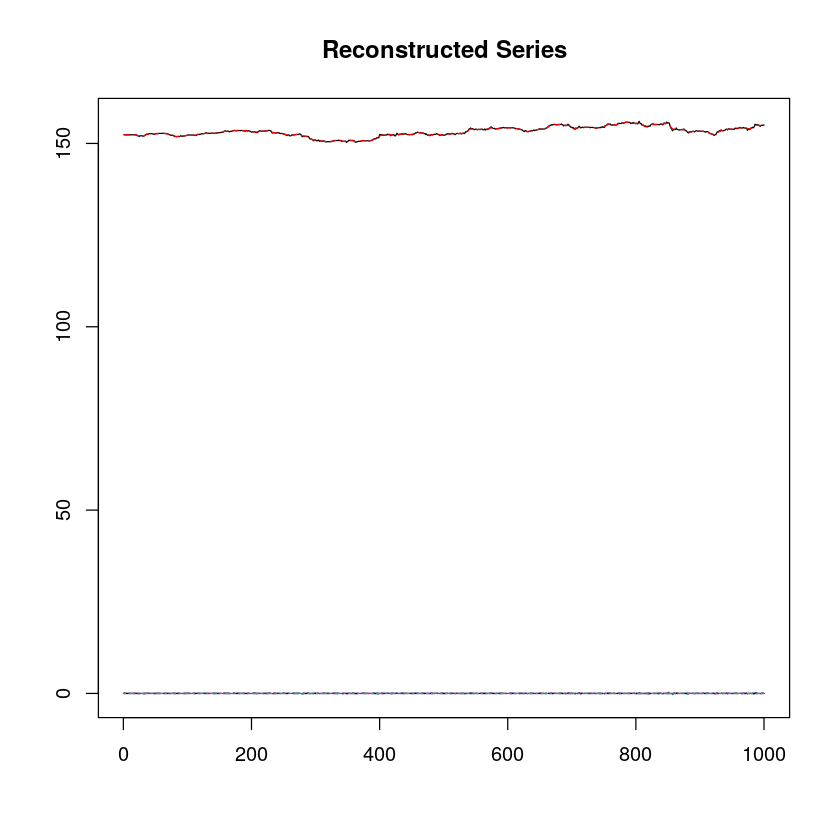

In [36]:
plot(recon)

In [32]:
mfs <- eemd(x[1:1000], num_siftings = 10, ensemble_size = 50, threads = 1)

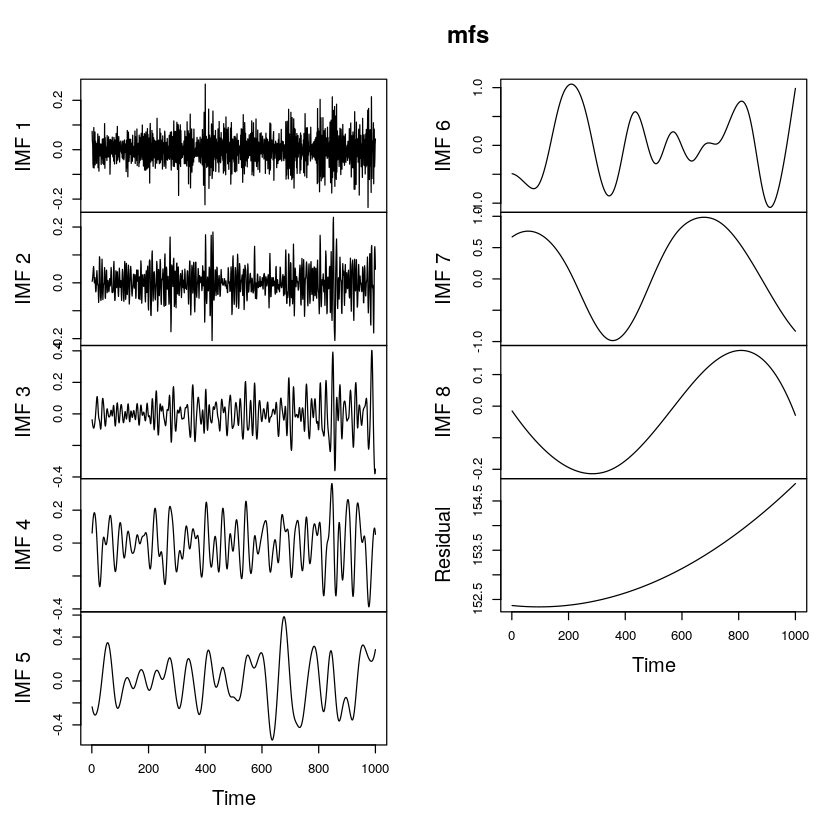

In [33]:
plot(mfs)

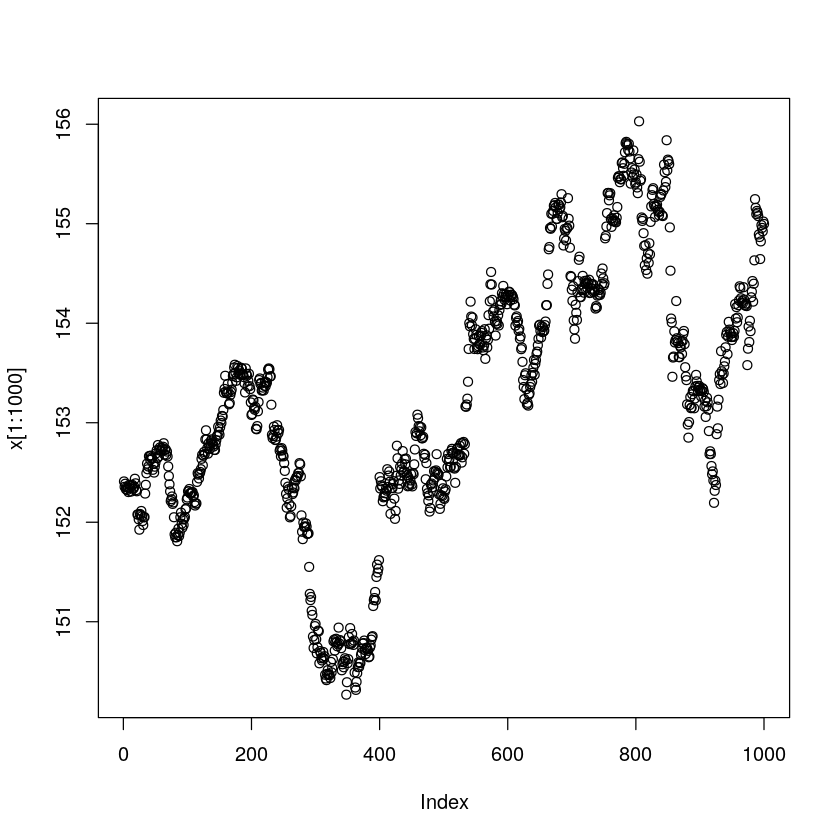

In [38]:
plot(x[1:1000])

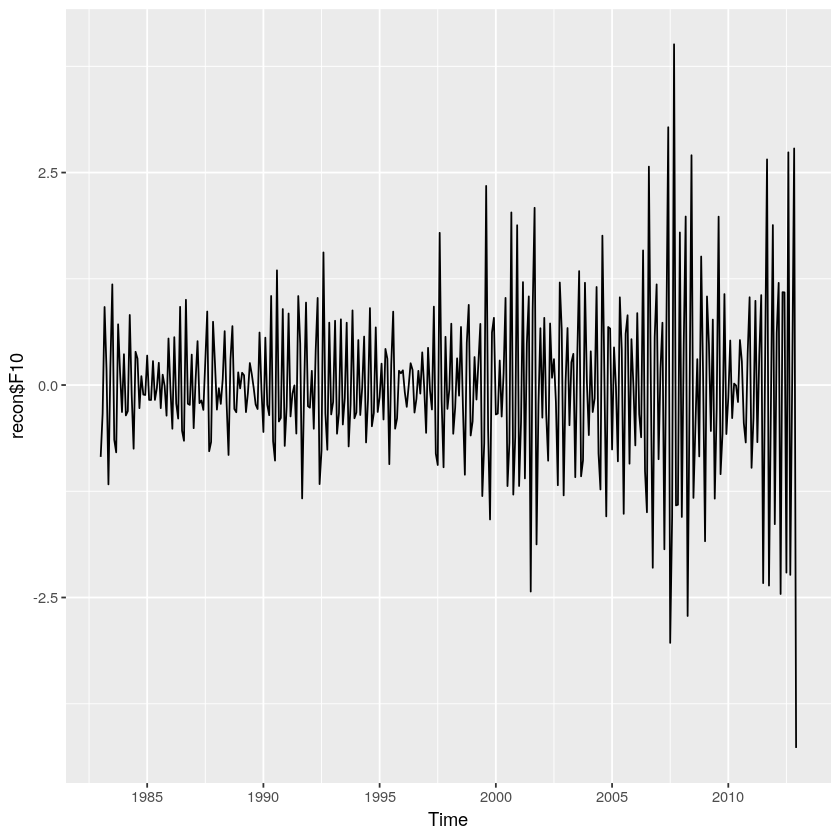

In [119]:
autoplot(recon$F10)

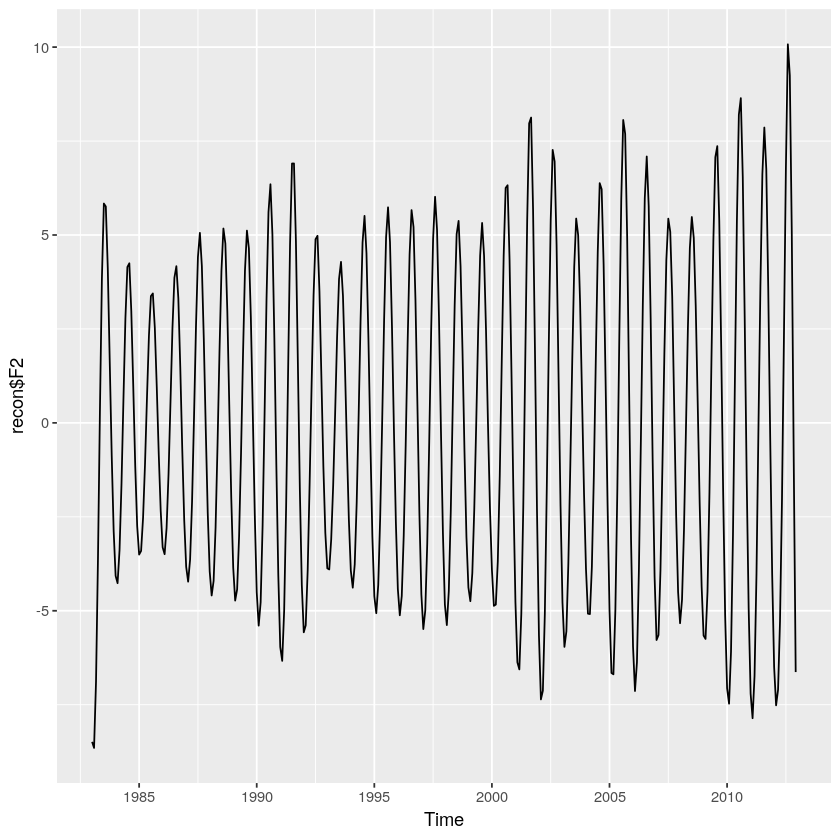

In [120]:
autoplot(recon$F2)

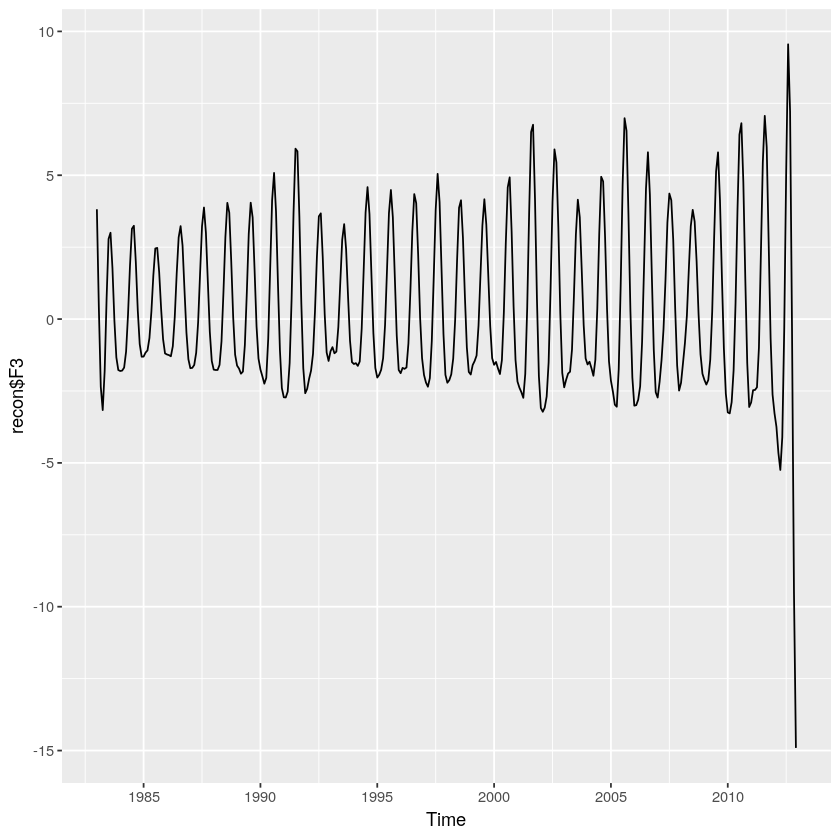

In [121]:
autoplot(recon$F3)

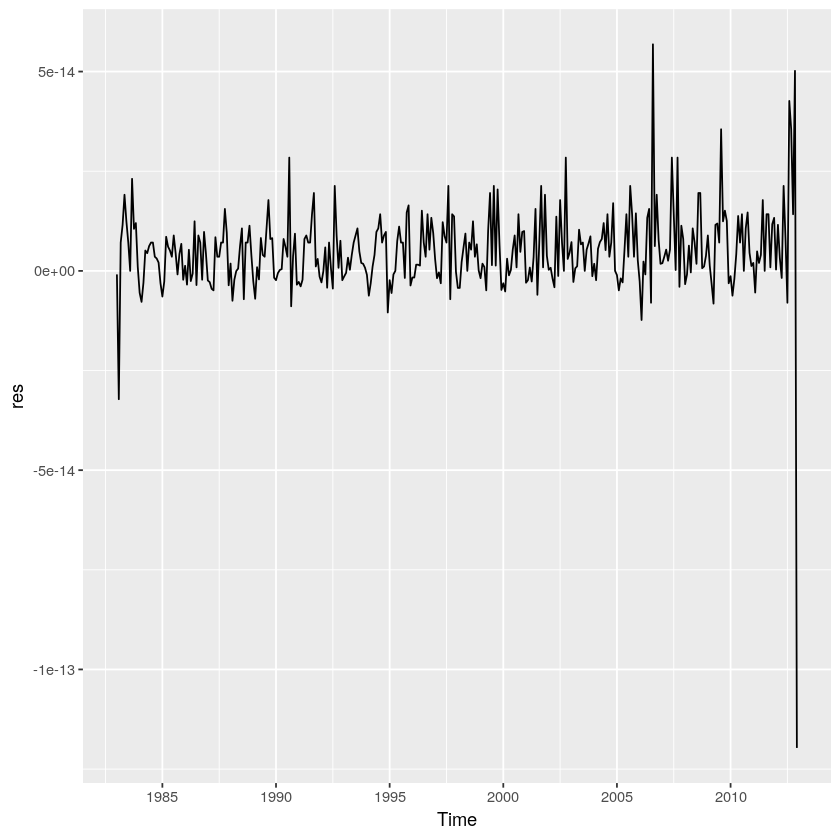

In [122]:
autoplot(res)

In [123]:
s = recon[[1]]
for(i in seq(2,L)){
s = s + recon[[i]]
}
s = s + res

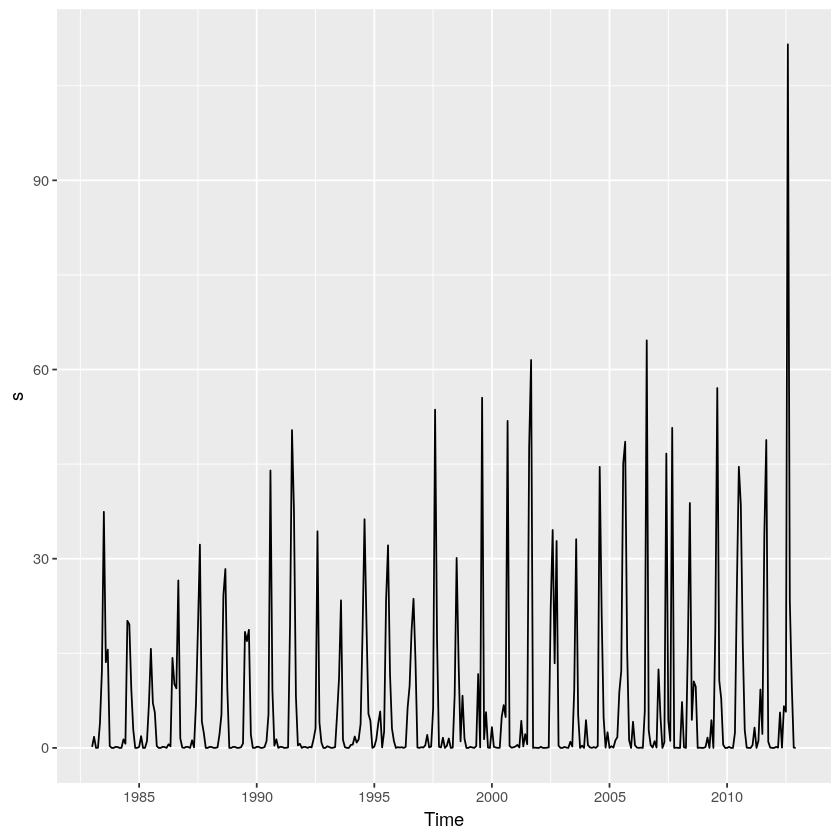

In [124]:
autoplot(s)

Don't know how to automatically pick scale for object of type ts. Defaulting to continuous.


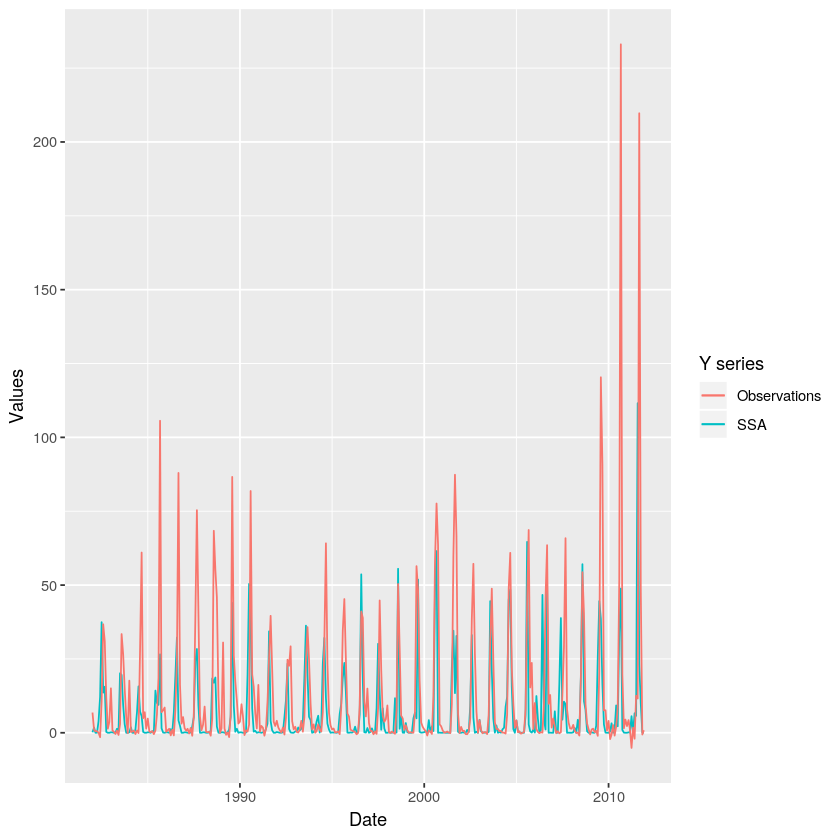

In [125]:
#y<-recon$F1 + recon$F2 + recon$F3+recon$F4+recon$F5+recon$F6
data <- data.frame(
  date = seq(as.Date("1982/1/1"), by = "month", length.out = length(x.train)),
  x.train,
  s
)

ggplot(data, aes(x=date)) +                    # basic graphical object
  geom_line(aes(y=x.train,colour="red") ) +  # first layer
  geom_line(aes(y=y,colour="blue"))+ ylab("Values")+ xlab("Date")+
  scale_color_discrete(name = "Y series", labels = c("Observations", "SSA"))

In [134]:
L = 20
s <- ssa(x.train, L = L)
# Reconstruction stage
# The results are the reconstructed series r$F1, r$F2, and r$F3
recon <- reconstruct(s)
# Calculate the residuals
res <- residuals(recon)

In [135]:
result = matrix(0.0,L,h)
for(i in c(1:L)){
    #lambda <- BoxCox.lambda(mfs[,i])
    result[i,] = forecast(ets(recon[[i]], biasadj = TRUE),h, biasadj = TRUE)$mean      
}

In [136]:
SSA = colSums(result)
SSA[SSA<0]<-0
SSA = ts(SSA, start = c(origin+z+n_train, 1), freq=f)

# error.A = accuracy(ABCZT, x.test)
accuracy(SSA, x.test)

ME       RMSE     MAE      MPE  MAPE ACF1      Theil's U
Test set 6.840885 16.08359 7.525838 -Inf Inf  0.3187837 0

In [128]:
result = matrix(0.0,L,h)
for(i in c(1:L)){
    #lambda <- BoxCox.lambda(mfs[,i])
    result[i,] = forecast(auto.arima(recon[[i]], biasadj = TRUE),h, biasadj = TRUE)$mean      
}

In [129]:
SSA = colSums(result)
SSA[SSA<0]<-0
SSA = ts(SSA, start = c(origin+z+n_train, 1), freq=f)

# error.A = accuracy(ABCZT, x.test)
error.E = accuracy(SSA, x.test)


In [130]:
error.E

ME        RMSE     MAE      MPE  MAPE ACF1     Theil's U
Test set -1.270071 20.03149 10.87082 -Inf Inf  0.156553 0

In [80]:
pa = phase_average(x.train, f)
x.train.t <- ts(pa$result, start = c(origin, 1), freq=f)

APA = forecast(auto.arima(x.train.t),h=h)$mean
APA = inv_phase_average(APA, f, pa$averages, pa$stds)

In [81]:
accuracy(APA, x.test)

ME       RMSE     MAE      MPE       MAPE     ACF1       Theil's U
Test set 3.601639 26.30623 11.56245 -312.6827 334.6182 -0.3513565 0.8738356

# ARFIMA

In [114]:
load("data.RData")
load("lat.RData")
load("lon.RData")


#x<-data[22,8,2:dim(data)[3]]  #cluster==2
#x<-data[28,7,3:dim(data)[3]]   #cluster==0
x<-data[22,8,]
#x<-df_cluster[["X1"]]
x.ts<-ts(x, start = c(1946, 1), freq=f)

#x <- fuzzify(x)

n=20
# Set forecasting window length (in years)
m=3
# Set start year
start = 1946
origin = 1990
# Set annual sampling rate
f = 12
h = m*f
start_month = 1

index = (origin - start) * f +1

#x.ts <- x[index:length(x)-1]

train_start <- index
train_end <- train_start+n*f-1

test_start <- train_end + 1
test_end <- test_start + m*f -1

x.train <- x[train_start:train_end]
x.test <- x[test_start:test_end]
#reg.train<-df[train_start:train_end,]
#reg.test<-df[test_start:test_end,]

x.ts = ts(x, start=c(origin, 1), freq=f)

x.train <- ts(x.train, start = c(origin, 1), freq=f)
#reg.train <- ts(reg.train, start = c(origin, 1), freq=f)
x.test <- ts(x.test, start = c(origin+n, 1), freq=f)
#reg.test <- ts(reg.test, start = c(origin+n, 1), freq=f)

lambda <- BoxCox.lambda(x.train)

In [117]:
a<-c(NA,1,2,3)

In [120]:
mean(a, na.rm = TRUE)

[1] 2

In [115]:
pa = phase_average(x.train, 12)
x.train.t <- ts(pa$result, start = c(origin, start_month-1), freq=f)

APA = forecast(auto.arima(x.train.t),h=h)$mean
APA = inv_phase_average(APA, f, pa$averages, pa$stds)

In [116]:
accuracy(APA, x.test)

ME           RMSE      MAE       MPE  MAPE ACF1        Theil's U
Test set -0.004038804 0.4499005 0.2079555 -Inf Inf  -0.05075519 0

In [9]:
x = df[["Close"]]

In [11]:
library(TSA)


Attaching package: ‘TSA’

The following objects are masked from ‘package:stats’:

    acf, arima

The following object is masked from ‘package:utils’:

    tar



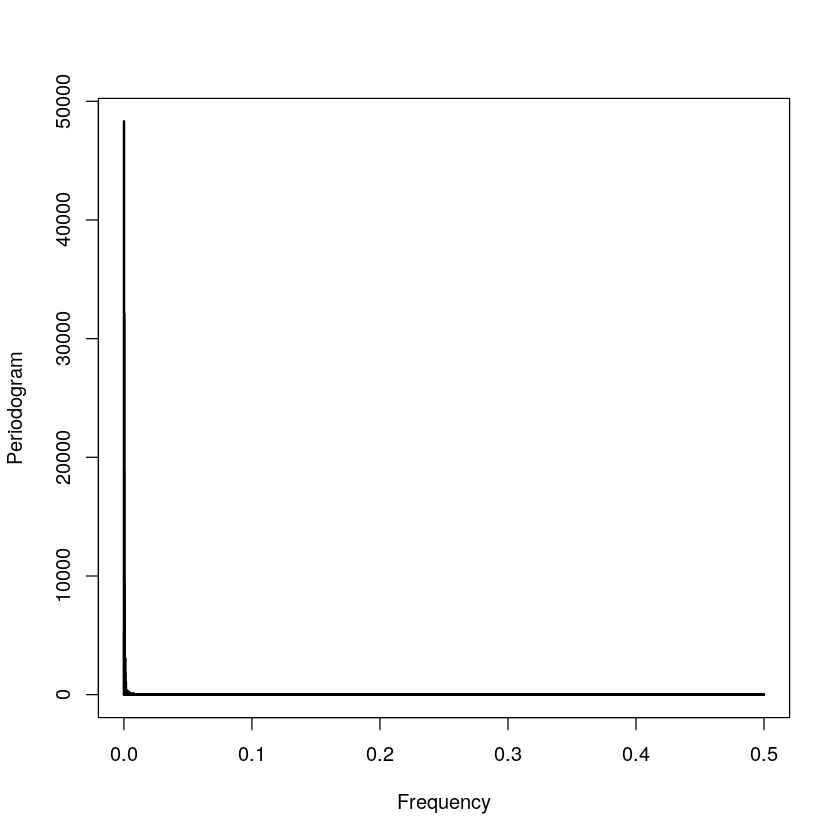

In [12]:
p = periodogram(x)

In [16]:
dd = data.frame(freq=p$freq, spec=p$spec)
order = dd[order(-dd$spec),]
top2 = head(order, 5)

In [17]:
top2

freq         spec     
1 8.333333e-05 48312.923
4 3.333333e-04 32090.646
3 2.500000e-04 18822.528
5 4.166667e-04  9481.693
6 5.000000e-04  7546.061

In [18]:
time = 1/top2$f
time

[1] 12000  3000  4000  2400  2000

In [28]:
fit  = arfima(x.train)

In [29]:
aa = forecast(fit,h=h)$mean

In [30]:
accuracy(aa, x.test)

ME        RMSE     MAE     MPE       MAPE     ACF1       Theil's U
Test set -2.765146 9.203117 7.92339 -4019.498 4040.547 0.01325408 1.899458

In [31]:
A=forecast(auto.arima(x.train), h=h)$mean

In [32]:
accuracy(A, x.test)

ME        RMSE     MAE      MPE       MAPE     ACF1       Theil's U
Test set -2.380633 9.061826 7.588675 -3370.549 3391.445 0.02607968 1.766483

In [10]:
install.packages("rstan")

Warning message in install.packages("rstan"):
“installation of package ‘rstan’ had non-zero exit status”Updating HTML index of packages in '.Library'
Making 'packages.html' ... done


In [1]:
install.packages("prophet")

also installing the dependency ‘rstan’

Warning message in install.packages("prophet"):
“installation of package ‘rstan’ had non-zero exit status”Warning message in install.packages("prophet"):
“installation of package ‘prophet’ had non-zero exit status”Updating HTML index of packages in '.Library'
Making 'packages.html' ... done


In [2]:
library(prophet)

ERROR: Error in library(prophet): there is no package called ‘prophet’


In [154]:
prophet.forecst<-function(y,year,month, n, h){

   start_date = paste(year,month,"01", sep = "-")
   if(month==1){
       month=12
   }else{
       month = month -1
   }
   end_date = paste(year+n-1,month,"01", sep = "-")

   ds = seq(from = as.Date(start_date), to = as.Date(end_date), by = 'month')
   df <- data.frame(ds,y)

   m <- prophet(df, weekly.seasonality=FALSE, daily.seasonality = FALSE)
   future <- make_future_dataframe(m, periods = h, freq='month')
   forecast <- predict(m, future)
   yhat<-tail(forecast$yhat, n = h)
 return(yhat)
}

In [123]:
load("data.RData")
load("lat.RData")
load("lon.RData")
    
n_train = 30
# Set forecasting window length (in years)
n_test = 3
# Set start year
start_year = 1946
# Set annual sampling rate
f = 12
h = n_test * f

skill <- list()

length.lon = dim(data)[1]
length.lat = dim(data)[2]
L = dim(data)[3]

end_year = start_year + ((L -(L %% f))/f)

df.A<-data.frame(as.numeric,as.numeric,as.numeric, as.numeric, as.numeric, as.numeric, as.numeric )
names(df.A)<-c("i","j","lon","lat","RMSE","MAE","meanErrorRatio")

df.E<-data.frame(as.numeric,as.numeric,as.numeric, as.numeric, as.numeric, as.numeric, as.numeric)
names(df.E)<-c("i","j","lon","lat","RMSE","MAE","meanErrorRatio")

#for(j in c(2:L)){

for(i in c(1:1)){
  for(j in c(10:10)){
    if(!is.na(data[i,j,L])){

      x <- data[i,j,]
      x <- sapply(x, fuzzify)

      RMSE.A = array(0.0, (end_year-(n_train+n_test))-start_year+1)
      MAE.A = array(0.0, (end_year-(n_train+n_test))-start_year+1)
      errorRatio.A = array(0.0, (end_year-(n_train+n_test))-start_year+1)

      RMSE.E = array(0.0, (end_year-(n_train+n_test))-start_year+1)
      MAE.E = array(0.0, (end_year-(n_train+n_test))-start_year+1)
      errorRatio.E = array(0.0, (end_year-(n_train+n_test))-start_year+1)

      x.ts <- x[1:length(x)-1]
      origin = start_year - 1
      N = length(x.ts)

      for(z in seq(1,N/f - n_train - n_test + 1)){

        train_start = (z - 1)*f + 1
        train_end = train_start + n_train*f - 1

        test_start = train_end + 1
        test_end = test_start + n_test*f - 1


        x.train <- x[train_start:train_end]
        x.test <- x[test_start:test_end]

        x.train <- ts(x.train, start = c(origin+z, 1), freq=f)
        x.test <- ts(x.test, start = c(origin+z+n_train, 1), freq=f)

        lambda <- BoxCox.lambda(x.train)

#APA = forecast(auto.arima(x.train.t),h=h)$mean
    #APA = inv_phase_average(APA, f, pa$averages, pa$stds)

    #EPA = forecast(ets(x.train.t),h=h)$mean
    #EPA = inv_phase_average(EPA, f, pa$averages, pa$stds)

    #OM + BC + PA
    #x.train.t <- BoxCox(x.train, lambda)
    #pa = phase_average(x.train.t, f)
    #x.train.t <- ts(pa$result, start = c(origin, 1), freq=f)

    #ABCPA = forecast(auto.arima(x.train.t),h=h)$mean
    #ABCPA = inv_phase_average(ABCPA, f, pa$averages, pa$stds)
    #ABCPA = invBoxCox(ABCPA,lambda)

    #EBCPA= forecast(ets(x.train.t),h=h)$mean
    #EBCPA = inv_phase_average(EBCPA, f, pa$averages, pa$stds)
    #EBCPA = invBoxCox(EBCPA,lambda)

    #E + STL
    #ES = forecast(stl(x.train,s.window="periodic", robust = TRUE), h=h, biasadj=FALSE)$mean

    #E + BC + STL
    #x.fit = stl(BoxCox(x.train,lambda), s.window="periodic", robust = TRUE)
    #EBCSTL = forecast(x.fit, h=h, lambda=lambda, biasadj=FALSE)$mean

   #A+EEDM
   mfs <- eemd(x.train, num_siftings = 10, ensemble_size = 50, threads = 1)
   n_mfs = dim(mfs)[2]
   result = matrix(0.0,n_mfs,h)
   for(k in c(1:n_mfs)){
   #lambda <- BoxCox.lambda(mfs[,i])
     # r = try(forecast(ets(mfs[,k]),h=h)$mean)
      r = try(forecast(auto.arima(mfs[,k]),h=h)$mean)
      if(is.numeric(r)){
        result[k,] = r
      }else{
        print(i)
        print(j)
        print(k)
        result[k,] = rep(NA,h)
      }
   }
   EEMD = colSums(result, na.rm = TRUE)
   EEMD[EEMD<0]<-0
   EEMD = ts(EEMD, start = c(origin+z+n_train, 1), freq=f)

   # error.A = accuracy(ABCZT, x.test)
    error.E = accuracy(EEMD, x.test)

   # RMSE.A[z] = as.numeric(error.A[1,2])
   # MAE.A[z] = as.numeric(error.A[1,3])
   # errorRatio.A[z] = RMSE.A[z]/mean(x.test)


    RMSE.E[z] = as.numeric(error.E[1,2])
    MAE.E[z] = as.numeric(error.E[1,3])
    print(RMSE.E[z])
    print(mean(x.test))
    errorRatio.E[z] = RMSE.E[z]/mean(x.test)
    print(errorRatio.E[z])
  }
  # Now calculate average forecast errors
  #meanRMSE.A = mean(RMSE.A, na.rm=TRUE)
  meanRMSE.E = mean(RMSE.E, na.rm=TRUE)
 # meanErrorRatio.A = mean(errorRatio.A)

 # meanMAE.A = mean(MAE.A, na.rm=TRUE)
  meanMAE.E = mean(MAE.E, na.rm=TRUE)
  meanErrorRatio.E = mean(errorRatio.E, na.rm=TRUE)

 # de.A<-data.frame(i,j,lon[i],lat[j],meanRMSE.A, meanMAE.A, meanErrorRatio.A)
  de.E<-data.frame(i,j,lon[i],lat[j],meanRMSE.E, meanMAE.E, meanErrorRatio.E)

 # names(de.A)<-c("i","j","lon","lat","meanRME", "meanMAE","meanErrorRatio")
  names(de.E)<-c("i","j","lon","lat","meanRME", "meanMAE","meanErrorRatio")

 # write.table(de.A, "ABCZTTemp.csv", sep = ",", col.names = !file.exists("ABCZTTemp.csv"), append = T)
  write.table(de.E, "./AEEMDTemp30.csv", sep = ",", col.names = !file.exists("./AEEMDTemp30.csv"), append = T)

 # df.A <- rbind(df.A,de.A)
  df.E <- rbind(df.E,de.E)
    }
  }
}


In [125]:
RMSE.E

[1] 33.96294 18.60553 18.92766 28.92424 16.45105  0.00000  0.00000  0.00000
 [9]  0.00000  0.00000  0.00000  0.00000  0.00000  0.00000  0.00000  0.00000
[17]  0.00000  0.00000  0.00000  0.00000  0.00000  0.00000  0.00000  0.00000
[25]  0.00000  0.00000  0.00000  0.00000  0.00000  0.00000  0.00000  0.00000
[33]  0.00000  0.00000  0.00000  0.00000  0.00000  0.00000

In [127]:
errorRatio.E

[1] 3.384449 1.894067 1.323869 2.241368 1.476534 0.000000 0.000000 0.000000
 [9] 0.000000 0.000000 0.000000 0.000000 0.000000 0.000000 0.000000 0.000000
[17] 0.000000 0.000000 0.000000 0.000000 0.000000 0.000000 0.000000 0.000000
[25] 0.000000 0.000000 0.000000 0.000000 0.000000 0.000000 0.000000 0.000000
[33] 0.000000 0.000000 0.000000 0.000000 0.000000 0.000000

In [136]:
z = 6

In [137]:
month <- z %% f

In [141]:
year <- z %/% f + 1946

In [142]:
year

[1] 1946

In [143]:
month

[1] 6

In [146]:
paste(12,"s", sep = "-")

[1] "12-s"

In [148]:
month-1

[1] 5

In [152]:
if(month==1){
    month=12
}else{
    month = month -1
}

In [153]:
month

[1] 12

In [151]:
month =1